# Assignment 1

*Part of the course:
Machine Learning (code: INFOB3ML), fall 2025, Utrecht University*

Total points: 10

Deadline: Friday 12 September, 23:59

- Luc Hampsink 8980713
- Mia Loozekoot 5022681

* Code is graded based on whether it runs correctly, but also based on code quality. Write legible code, use sensible variable names, and make sure your code is properly commented.
* Submit your code in Brightspace. See the instructions in Brightspace.

**Before you submit, click Kernel > Restart Kernel and Run All Cells to make sure you submit a working version of your code!**

## Linear Regression with Regularisation
In this assignment, you will perform several simulation experiments with linear regression, in order to investigate the effects of regularisation.

## Overview
### Data generation
Every datapoint $(x,t)$ will be sampled randomly, with both $x$ and $t$ in $\mathbb{R}$. (Note that the book from Introduction to Machine Learning called the output $y$, while this course's book calls it $t$.) The input $x$ is uniformly distributed between $-1$ and $1$.

Once we have our input $x$, we generate our output $t$ according to $t = 1 - \cos(x) + \epsilon$, where $\epsilon$ is normally distributed with expected value = 0 and variance = $\sigma^2$.
All the random numbers should be generated **independently** from one another.

### Regression

We'll implement *regularised* regression, adding a penalty $\lambda \mathbf{w}^T \mathbf{w}$ to our training loss. Linear regression with this form of regularisation penalty is also called *ridge regression*. We are going to try out different values of $\lambda$.

We'll use regression with order five polynomials like in the book. This means that for each weight vector $\mathbf{w}$, our hypothesis is of the form
$$f(x; \mathbf{w}) = \sum_{i=0}^5 w_i x^i.$$

## Your Code

To make it clear what your code is supposed to do and how it should be formatted, we provide you general schema for each to-be-written function. Some functions come with additional hints about useful in-built functions or procedural details. You might write the function's body differently than the hints suggests. That's totally fine as long as the function works as it supposed to work.

Use numpy arrays for functionalities involving vectors and matrices. [Here is an overview of numpy, which includes many functions you'll find useful in this course, as well as some more advanced ones.](https://numpy.org/doc/stable/user/quickstart.html)

Some specific notes about numpy:

* Make sure to use numpy arrays (`np.ndarray`), not `np.matrix`! Arrays are the standard choice, and they can represent vectors, matrices, as well as more general objects. Some of the pre-written code below won't work if you use `np.matrix`.

* To multiply two matrices, write `A @ B`. It is a shorthand for the function [`matmul`](https://numpy.org/doc/stable/reference/generated/numpy.matmul.html).

* To generate random numbers, use for instance [`rg.uniform`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.uniform.html#numpy.random.Generator.uniform) and [`rg.normal`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.normal.html#numpy.random.Generator.normal). (The `rg` here is a random number generator object, created in the TEST block below.)

### Data generation with noise

**Task 1** (1 point)

Write a function `generate_data` you can use to generate a dataset and outputs the pair of vectors `(x,t)`, accepting parameters $N$ and $\sigma^2$. Be sure to check if your normal-distribution-generator needs $\sigma$ (standard deviation) or $\sigma^2$ (variance) as input parameter. Both `x` and `t` should be 1-dimensional numpy arrays, i.e. their shape should be `(N,)`.

In [106]:
import numpy as np
import math

# Some functions you may find useful (here and later):
# np.cos, np.ones, np.linalg.inv, np.hstack, np.matmul (or @), np.eye, math.sqrt.

def generate_data(
        N: int, sigma_squared: float
) -> tuple[np.ndarray, np.ndarray]:
    # Your code here
    x = np.random.uniform(0, 1, N)
    noise = np.random.normal(0, math.sqrt(sigma_squared), N)
    t = 1 - np.cos(x) + noise 
    return x, t

In [107]:
# ██████████ TEST ██████████
# (These "TEST" blocks can help you quickly check if there's something
# obviously wrong with the code you wrote.)
# Setting a seed with the optional argument to default_rng below makes
# the data generation deterministic, which can make it easier to
# compare different versions of your code.
rg = np.random.default_rng(seed = 1)
toy_xs, toy_t = generate_data(3, 0.1)
# Check if the shapes of the output arrays are as specified above:
print(toy_xs.shape)
print(toy_xs)
print(toy_t.shape)
print(toy_t)

(3,)
[0.88782946 0.83029319 0.01846991]
(3,)
[-0.17141786  0.22074811 -0.07814916]


Next, in order to learn 5th-order polynomials, we want to have a function that computes the matrix $\mathbf{X}$. (See equation (1.18) on page 28 of the book for what this matrix should look like.)

**Question 2** (1 point)

(a) When dealing with $N$ data points, what should the size of the $\mathbf{X}$-matrix be? (Give the number or rows and the number of columns.)

(b) Where in the matrix will you find the vector `x_scalars`?

(c) Where in the matrix will you find $\mathbf{x}_1$ (the feature vector associated to the first data point)?

a) Assuming a 5th-order polynomial, the matrix should have $5+1$ columns (5 orders and a scalar from x^0) and $N$ rows.

b) The vector $x_{scalars}$ will be the first column of the matrix.
    - The function from the book applies for $x^0 = 1$: $f(x; w) = \sum_{k=0}^K w_k x^k$
    - $x^0_?$ is in the first column of the matrix.

c) $x_1$ can be found in the first row of the matrix (indices start at 1).
   The row is made up of the different order parameters k: $x_1^k$.

**Task 3** (1 point)

Write a function `compute_X_matrix` that takes a numpy array `x_scalars` as produced by your code above, and returns the matrix `X` needed for linear regression with 5th-order polynomials.

In [108]:
def compute_X_matrix(x_scalars):
    # Your code here
    # 5-th order, so there are six columns.
    X = np.zeros((len(x_scalars), 6))
    for i in range(len(x_scalars)):
        for n in range(6):
            X[i, n] = x_scalars[i] ** n
    return X

In [109]:
# ██████████ TEST ██████████
toy_X = compute_X_matrix(toy_xs)
print(toy_xs)
print(toy_X)

[0.88782946 0.83029319 0.01846991]
[[1.00000000e+00 8.87829464e-01 7.88241158e-01 6.99823725e-01
  6.21324123e-01 5.51629863e-01]
 [1.00000000e+00 8.30293188e-01 6.89386778e-01 5.72393146e-01
  4.75254130e-01 3.94600266e-01]
 [1.00000000e+00 1.84699145e-02 3.41137742e-04 6.30078493e-06
  1.16374959e-07 2.14943554e-09]]


### Fitting linear regression

The function provided below will plot the target function $1 - \cos(x)$, a regression function, and the training data all in one plot. It will be helpful in testing your code for the task below.

In [110]:

import matplotlib.pyplot as plt

def plot_regression_result(xs_train, t_train, w, include_target_function=True):
    # Create analogues for x_scalars and X, but for a grid of evenly spaced points between -2 and 2.
    xs_plot = np.linspace(-2, 2, 101)
    X_plot = compute_X_matrix(xs_plot)
    # Plot the target function.
    if include_target_function:
        plt.plot(xs_plot, 1 - np.cos(xs_plot), c='black')
    # Plot the training data.
    plt.scatter(xs_train, t_train, c='blue', marker=".")
    # The y axis has been scaled automatically to fit the target function and data. Read the current limits.
    bottom, top = plt.ylim()
    # Plot the regression function.
    plt.plot(xs_plot, X_plot @ w, c='red')
    # Adjust the y axis so it will show the target function, the data, and the centre of the regression function.
    # The regression function can take very large/small values at -2 and 2, so we allow those to fall outside the figure.
    plt.ylim(min(bottom, w[0] - 0.5, -1), max(top, w[0] + 0.5))
    plt.show()

**Task 4** (1 point)

Write code that fits a regularised linear regression hypothesis to training data, in other words, a function that computes our $\hat{\mathbf{w}}$. Use numpy to carry out the necessary matrix operations to find an analytic solution; don't use linear regression functionality from Python packages for machine learning. In other words, compute $\hat{\mathbf{w}}$ according to the equation (1.21) on page 36 of the book. Give your function a parameter `lamb` which tells it the value of $\lambda$.
   

In [111]:
def fit_ridge(X, t, lamb):
    X_transpose = np.transpose(X)
    I = np.eye(X.shape[1])
    # ik heb w = (X^t X + \lamb * I)^-1 X_t t gebruikt
    w = np.linalg.inv(X_transpose @ X + lamb * I) @ X_transpose @ t
    return w

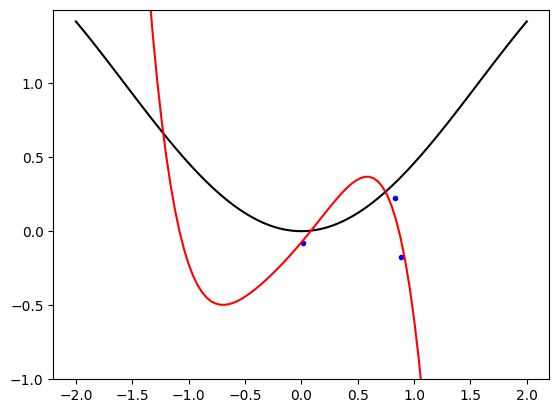

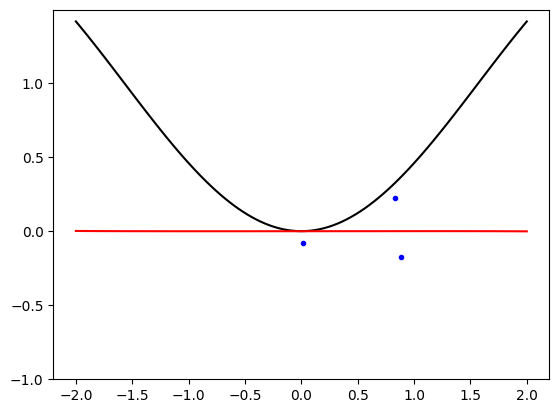

In [112]:
# ██████████ TEST ██████████
plot_regression_result(toy_xs, toy_t, fit_ridge(toy_X, toy_t, 0.01))
plot_regression_result(toy_xs, toy_t, fit_ridge(toy_X, toy_t, 100))

### Squared loss over the data

The following code (which you shouldn't change) evaluates a learned linear regression function $\hat{\mathbf{w}}$ with respect to the data $\mathbf{X}, \mathbf{t}$ using the squared error loss. This Python function can be used to compute training, validation or test loss for $\hat{\mathbf{w}}$, depending of the kind of data passed to it.

In [113]:
def compute_loss(w, X, t):
    N, k = X.shape
    t_hat = X @ w
    t_error = t_hat - t
    sum_of_squared_errors = t_error.T @ t_error
    loss = sum_of_squared_errors / N
    return loss

## The effect of $\lambda$

Now it's time to do some experiments and look at the results.

**Task 5** (1 point)

Generate a dataset of $N=20$ data points with noise level $\sigma^2 = 0.04$. (You'll use this dataset in tasks/questions 5 through 7.) For the values of $\lambda$ provided in the code below, fit a regularised regression curve to the data and compute the unregularised loss (using `compute_loss`). Display the results in a plot.

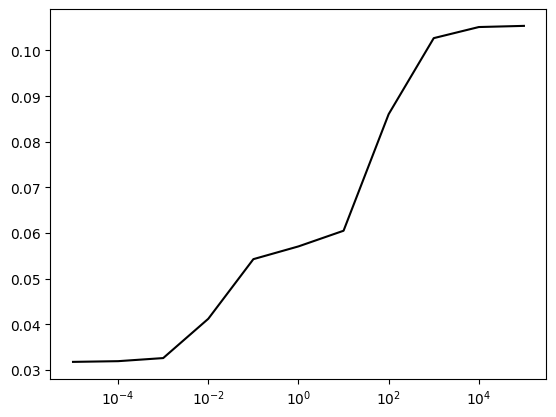

In [114]:
lambdas = 10 ** np.linspace(-5, 5, 11) # 10E-5, 10E-4, 10E-3, ..., 10E5
losses = np.zeros_like(lambdas)

rg = np.random.default_rng(seed = 1)

# Your code here

#generate data
N = 20
sigma_sq = 0.04
x_scalars, t = generate_data(N, sigma_sq)

#X_matrix
X = compute_X_matrix(x_scalars)

#plot
for i in range(len(lambdas)):
    w = fit_ridge(X, t, lambdas[i])
    losses[i] = compute_loss(w, X, t)

    
plt.semilogx(lambdas, losses, c='black')
plt.show()

**Question 6** (1 point) Your plot should show that as $\lambda$ gets larger, the loss also gets larger. Explain why this is to be expected.

*Your answer here*

**Task/Question 7** (1 point)

Using the same data, answer the following questions:

For what values of $\lambda > 0$ do you clearly see overfitting? For what values of $\lambda$ do you see underfitting? To support your answer, include plots for some values of $\lambda$, and point out what features of those plots tell you that over-/underfitting is going on.

lambda:  1e-05


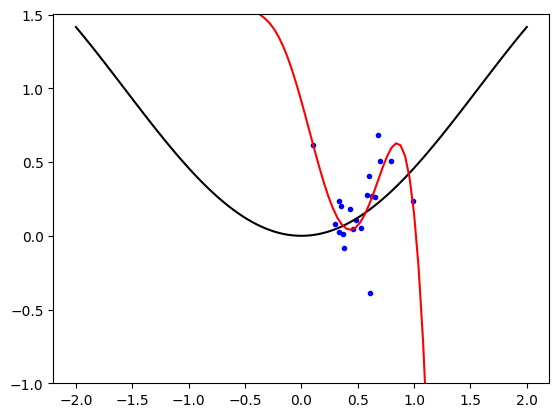

lambda:  0.0001


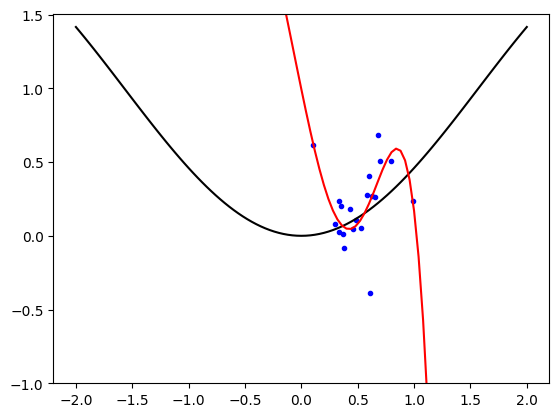

lambda:  0.001


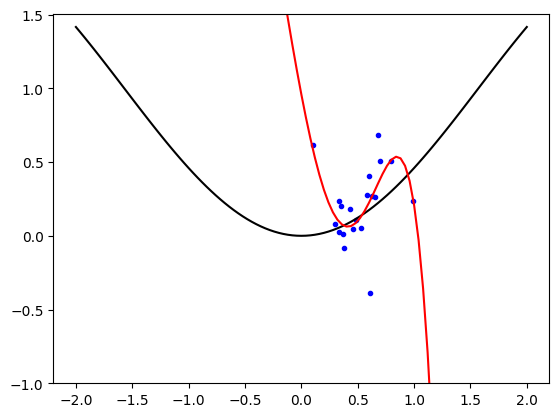

lambda:  0.01


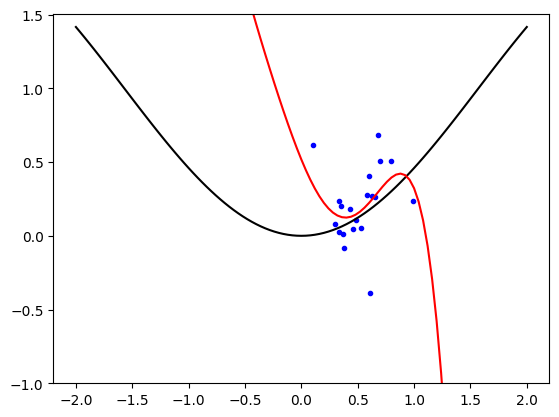

lambda:  0.1


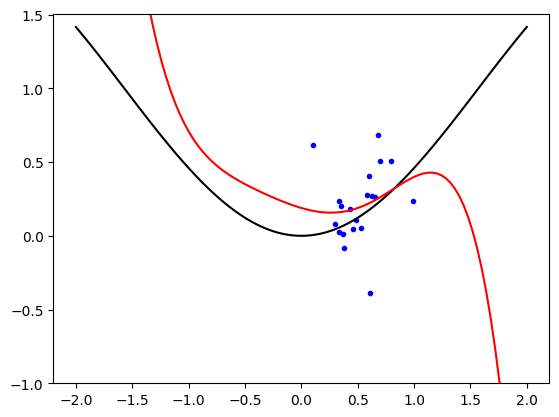

lambda:  1.0


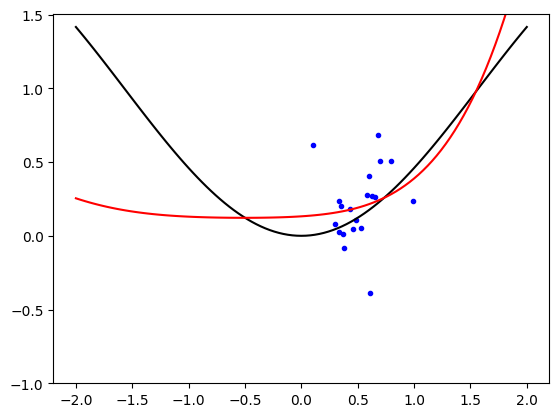

lambda:  10.0


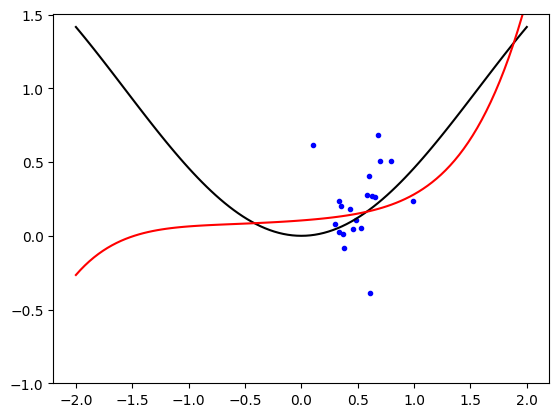

lambda:  100.0


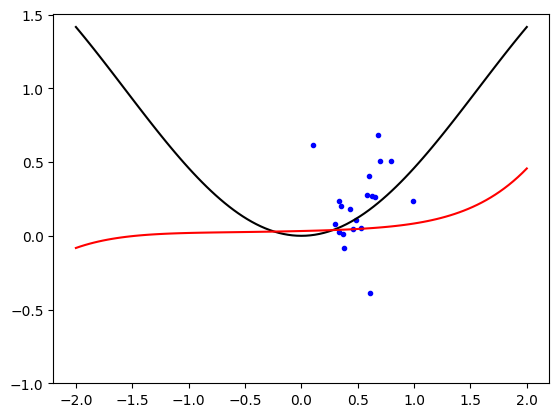

lambda:  1000.0


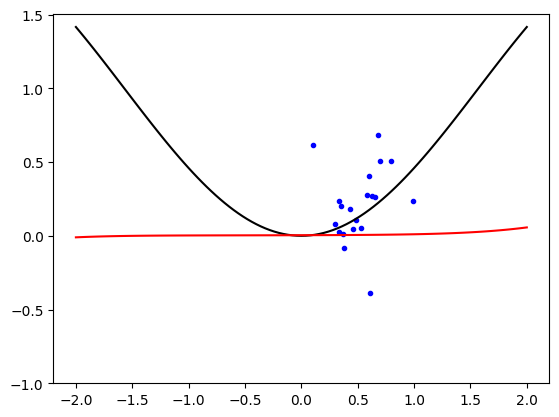

lambda:  10000.0


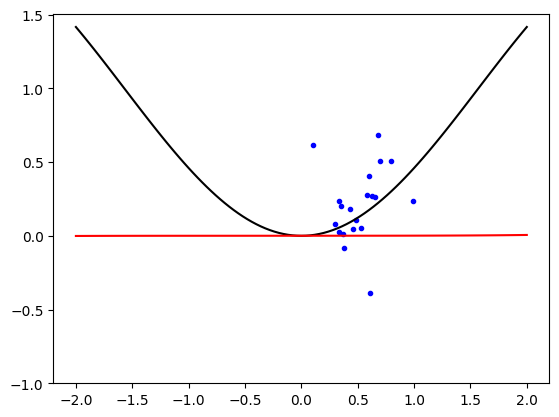

lambda:  100000.0


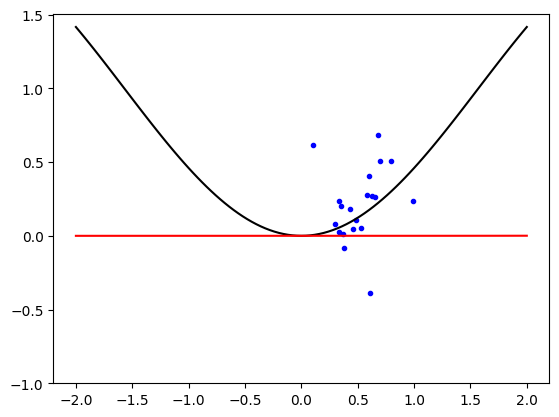

In [115]:
# Your code here
for lamb in lambdas:
    print("lambda: ", lamb)
    plot_regression_result(x_scalars, t, fit_ridge(X, t, lamb))


For lambda around 0.01 and 0.1 we see quite a resonable fit to the data. Larger lambas tend to underfit the data, as the line becomes progressively straighter and straighter. Lambda values of 0.001 and lower tend to overfit the data, as the line starts to follow the noise in the data, and become too wiggly.


## Cross-validation

To find a good value of $\lambda$, a variety of techniques exist. One that obviously does *not* work is to look at the training loss as a function of $\lambda$ (like you plotted above): that would always suggest to make $\lambda$ as small as possible! A versatile technique that you've already seen in an earlier course (or in section 1.5 of the book) is **cross-validation**.

**Task 8** (1 point)

Write some code to do the following: sample a new dataset of $N = 50$ data points and $\sigma^2=0.1$. (You'll use this dataset for all the remaining tasks and questions.) Write a function that computes the leave-one-out cross-validation (LOOCV) loss for given data and value of $\lambda$, as explained in section 1.5.2 of the book. Then make a plot similar to what we did in task 5 for the training loss, but this time displaying the LOOCV loss as a function of $\lambda$.

Note that the third argument, `fitting_function`, should be the name of a function that `LOOCV` can call to compute `w`. If `fit_ridge` is passed, your previously written function will be used. But later, you'll call it with a different fitting function.

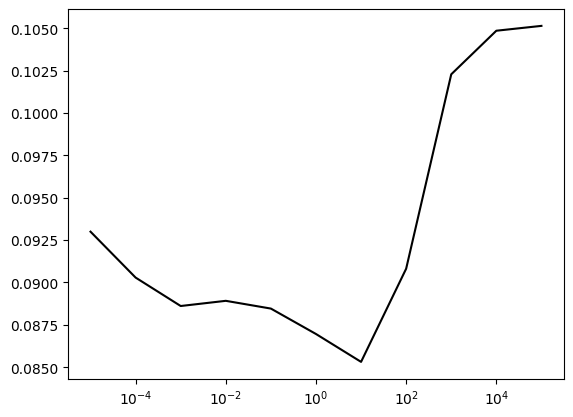

In [116]:
def LOOCV(X, t, fitting_function, lamb):
    N, k = X.shape
    sum_of_losses = 0.0
    for leave_out in range(N):
        # Your code here
        X_train = np.delete(X, leave_out, axis=0)
        t_train = np.delete(t, leave_out, axis=0)

        X_test = X[leave_out, :].reshape(1, -1)
        t_test = t[leave_out]

        w = fitting_function(X_train, t_train, lamb)
        sum_of_losses += compute_loss(w, X_test, t_test) 
    return sum_of_losses / N

# Your code here to sample a larger dataset, and to make the plot of the LOOCV loss for each lambda
N = 50
sigma_sq = 0.1
x_scalars, t = generate_data(N, sigma_sq)
X = compute_X_matrix(x_scalars)

fitting_function = fit_ridge

for i in range(len(lambdas)):
    losses[i] = LOOCV(X, t, fitting_function, lambdas[i])


plt.semilogx(lambdas, losses, c='black')
plt.show()

**Question 9** (0.5 points): What value of $\lambda$ does LOOCV point you to? Look at a plot of the resulting regression function. Does it look reasonable?

*Your answer here*

vgm ligt het zo tussen de 10 en 100, maar weet niet zeker of ik dit juist interpreteer. 

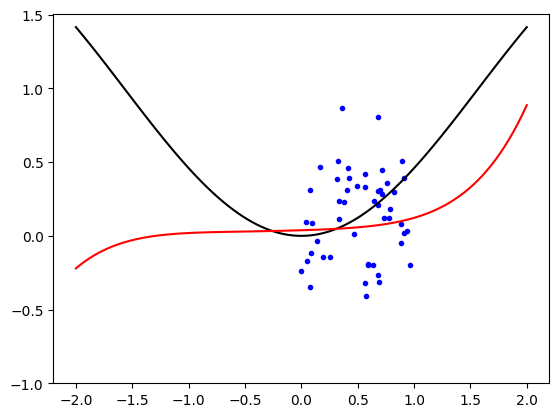

In [117]:
# Your code here

# Dit is gebaseerd op lambda = 100
w = fit_ridge(X, t, 100)
losses[i] = compute_loss(w, X, t)
plot_regression_result(x, t, w, include_target_function=True)

plt.show()

## Lasso regression

As the book mentions, when doing regularisation, using the squares of $\mathbf{w}$ as a penalty is just one of many possibilities. It has the advantage of having an analytical solution. But other options exist that may have other advantages, and while they may not be analytically computable, still there exist efficient algorithms for working with them. A particularly popular one is to use the sum of absolute values of $\mathbf{w}$ as a penalty: we will find the $\mathbf{w}$ that minimizes
$$\mathcal{L}' = \mathcal{L} + \lambda \sum_i \lvert w_i \rvert.$$
This is called the 'lasso' (which is an acronym for 'least absolute shrinkage and selection operator', but of course most people just remember the acronym).

There is no direct formula for computing the $\mathbf{w}$ that minimizes $\mathcal{L}'$. The next alternative would be to use (stochastic) gradient descent. Unfortunately, that also doesn't work very nicely here, because as a function of $\mathbf{w}$, $\mathcal{L}'$ is not differentiable wherever $\mathbf{w}$ has at least one entry equal to zero. But variants of gradient descent have been developed that can deal with this problem (such as [proximal gradient descent](https://en.wikipedia.org/wiki/Proximal_gradient_method)), and implementations are readily available. The fitting function provided below uses such an implementation.

In [118]:
from sklearn.linear_model import Lasso

def fit_lasso(X, t, lamb):
    clf = Lasso(lamb, fit_intercept=False, max_iter=100000)
    clf.fit(X, t)
    return clf.coef_

**Task 10** (0.5 point)

Again plot the LOOCV losses as a function of $\lambda$, but this time for lasso regression instead of ridge regression. Read off the value of $\lambda$ that minimizes the LOOCV loss, and display the regression function for that $\lambda$ in a separate plot.

/Users/luchampsink/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.216e-02, tolerance: 5.243e-04
  model = cd_fast.enet_coordinate_descent(
/Users/luchampsink/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.418e-02, tolerance: 5.238e-04
  model = cd_fast.enet_coordinate_descent(
/Users/luchampsink/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider

Best lambda: 0.01


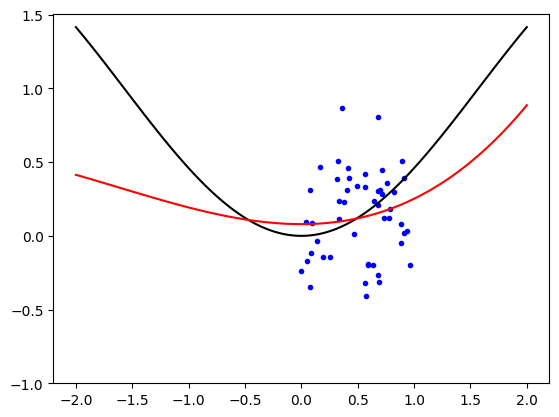

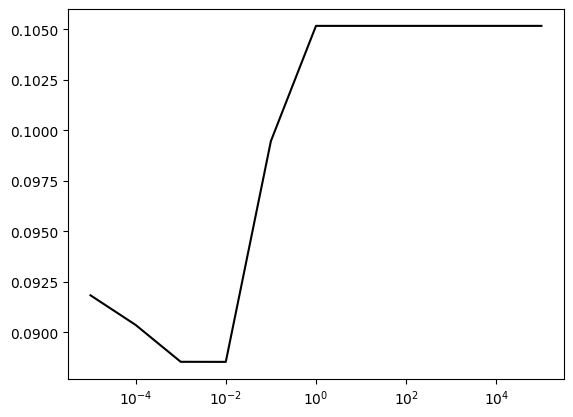

In [121]:
# Your code here
fitting_function = fit_lasso
for i in range(len(lambdas)):
    losses[i] = LOOCV(X, t, fitting_function, lambdas[i])

best_lambda = lambdas[np.argmin(losses)]
print("Best lambda:", best_lambda)
w = fit_lasso(X, t, best_lambda)
plot_regression_result(x, t, w)

plt.semilogx(lambdas, losses, c='black')
plt.show()

An important property of lasso regularisation is its tendency to make some weigths exactly equal to 0. (Well, mathematically that's true, but in a computation, you should never rely on things being *exactly* equal when a numerical algorithm is involved. Instead, check whether the difference between them is very small, say less than `1e-9`.)

**Task 11** (0.5 points)

What is the smallest $\lambda$ in `lambdas` for which you observe this happening for some $w_i$? For that combination of $\lambda$ and $i$, make a plot where $w_i$ varies along the horizontal axis. On the vertical axis, plot the regularised loss $\mathcal{L}'$ of the weight vector, with all entries other than $w_i$ kept equal to the optimal lasso solution for that $\lambda$. Choose the range of $w_i$-values small enough that you see a nondifferentiability in the graph.

In [120]:
# Your code here

**Question 12** (0.5 points): Use this graph to explain why lasso regression has a tendency to make some weights equal to 0. (By "tendency" we mean: if you generate random data from a suitable distribution, and look at the elements of $\mathbf{w}$, you'll see the number 0 much more often than any other number.)

*Your answer here*

    
---

<br>
<br>

**Remember: Before you submit, click Kernel > Restart Kernel and Run All Cells to make sure you submit a working version of your code!**